In [1]:
from pycelonis import get_celonis
from pycelonis.notebooks import api_tutorial

Ignoring 03_PQL_and_Python_1.ipynb because file already exists. To replace it, delete it first.
Ignoring 05_Celonis_Studio.ipynb because file already exists. To replace it, delete it first.
Ignoring 01_Pulling_data_from_dm.ipynb because file already exists. To replace it, delete it first.
Ignoring 02_Pushing_and_Editing_Data_in_Pool.ipynb because file already exists. To replace it, delete it first.
Ignoring 06_Anomaly_Detection_Demo.ipynb because file already exists. To replace it, delete it first.
Ignoring 04_PQL_and_Python_2.ipynb because file already exists. To replace it, delete it first.
Ignoring 01_Pulling_data.ipynb because file already exists. To replace it, delete it first.
Ignoring 07_IBM_Watson_integration_demo.ipynb because file already exists. To replace it, delete it first.
Ignoring 02_Adding_new_data_to_data_model.ipynb because file already exists. To replace it, delete it first.
Ignoring 00_Connecting_to_Celonis.ipynb because file already exists. To replace it, delete i

In [2]:
celonis = get_celonis(
          url= "https://academic-umut-dural-rwth-aachen-de.eu-2.celonis.cloud/",
          api_token= "MjIyYjViMDEtMDE4Yi00YTM0LWI0OGYtZjRlNjgyNDBkZmYyOnQySkRBV0hyUmFjUllWUldBeXZHaFFzZHRPN1psL21SVWFScXh0UjdUUkRE"
)


[2022-04-30 03:14:25] WARNING: Argument 'key_type' not set, defaults to 'APP_KEY'. Must be one of [USER_KEY, APP_KEY].


[2022-04-30 03:14:25] INFO: Initial connect successful! You are using an Application Key. PyCelonis Version: 1.7.0
[2022-04-30 03:14:26] INFO: Your key has following permissions:
[
    {
        "permissions": [],
        "serviceName": "package-manager"
    },
    {
        "permissions": [],
        "serviceName": "workflows"
    },
    {
        "permissions": [],
        "serviceName": "task-mining"
    },
    {
        "permissions": [],
        "serviceName": "team"
    },
    {
        "permissions": [],
        "serviceName": "action-engine"
    },
    {
        "permissions": [],
        "serviceName": "process-repository"
    },
    {
        "permissions": [
            "CREATE_WORKSPACE",
            "EDIT_ALL_ANALYSES",
            "EDIT_ALL_WORKSPACES",
            "USE_ALL_ANALYSES",
            "CREATE_ANALYSES",
            "EXPORT_CONTENT"
        ],
        "serviceName": "process-analytics"
    },
    {
        "permissions": [],
        "serviceName": "transformati

In [3]:
# celonis

In [4]:
print(celonis.datamodels)

[
<Datamodel, id 3cd8770b-7c1d-487e-b358-d9985ac83109, name SAP P2P>,
<Datamodel, id 955669d9-c78c-49eb-9982-85af2a7d1e24, name MobIS>,
<Datamodel, id 9dd4b299-80b9-497f-b760-7387035e8649, name BPI 2017>,
]


Selecting the MobIs Dataset


In [35]:
# GET DATA FROM CELONIS
mobis = celonis.datamodels.find("955669d9-c78c-49eb-9982-85af2a7d1e24")
print(mobis.tables.find('63cb0f9c-cbfd-4da0-b7a6-7232cba90992').columns)

from pycelonis.celonis_api.pql import pql
q = pql.PQL()
q += pql.PQLColumn('"mobis_challenge_log_2019_csv"."START"', 'time:timestamp')
q += pql.PQLColumn('"mobis_challenge_log_2019_csv"."CASE"', 'case:concept:name')
q += pql.PQLColumn('"mobis_challenge_log_2019_csv"."ACTIVITY"', "concept:name")
q += pql.PQLColumn('CLUSTER_VARIANTS ( VARIANT("mobis_challenge_log_2019_csv"."ACTIVITY"), 2, 1 )', 'Cluster')
# q += pql.PQLColumn("mobis_challenge_log_2019_csv.START", "start")
# q += pql.PQLFilter("Filter ACTIVIT_TABLE.ACTIVITY_EN != 'Create Case'; ")

df = mobis._get_data_frame(q)
df.head()

[{'name': 'ACTIVITY', 'length': 320, 'type': 'STRING'}, {'name': 'CASE', 'length': 19, 'type': 'INTEGER'}, {'name': 'START', 'length': 26, 'type': 'DATE'}, {'name': 'END', 'length': 26, 'type': 'DATE'}, {'name': 'TYPE', 'length': 320, 'type': 'STRING'}, {'name': 'USER', 'length': 320, 'type': 'STRING'}, {'name': 'TRAVEL_START', 'length': 26, 'type': 'DATE'}, {'name': 'TRAVEL_END', 'length': 26, 'type': 'DATE'}, {'name': 'COST', 'length': 15, 'type': 'FLOAT'}, {'name': '_CELONIS_CHANGE_DATE', 'length': 23, 'type': 'DATE'}]
[2022-04-30 03:30:17] INFO: PQL Export started...
[2022-04-30 03:30:17] INFO: PQL Export status: DONE


,time:timestamp,case:concept:name,concept:name,Cluster
0,2017-01-16 13:29:00,1,pay expenses,349
1,2017-01-16 08:38:00,5,pay expenses,349
2,2017-01-04 06:59:00,6,calculate payments,3
3,2017-02-06 09:27:00,6,pay expenses,3
4,2017-01-01 03:46:00,7,send original documents to archive,363


In [36]:
# DATAFRAME from Celonis to Log
import pm4py
log = pm4py.convert_to_event_log(df)
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
xes_exporter.apply(log, 'logs.xes')

parsing log, completed traces :: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6555/6555 [00:02<00:00, 2317.99it/s]


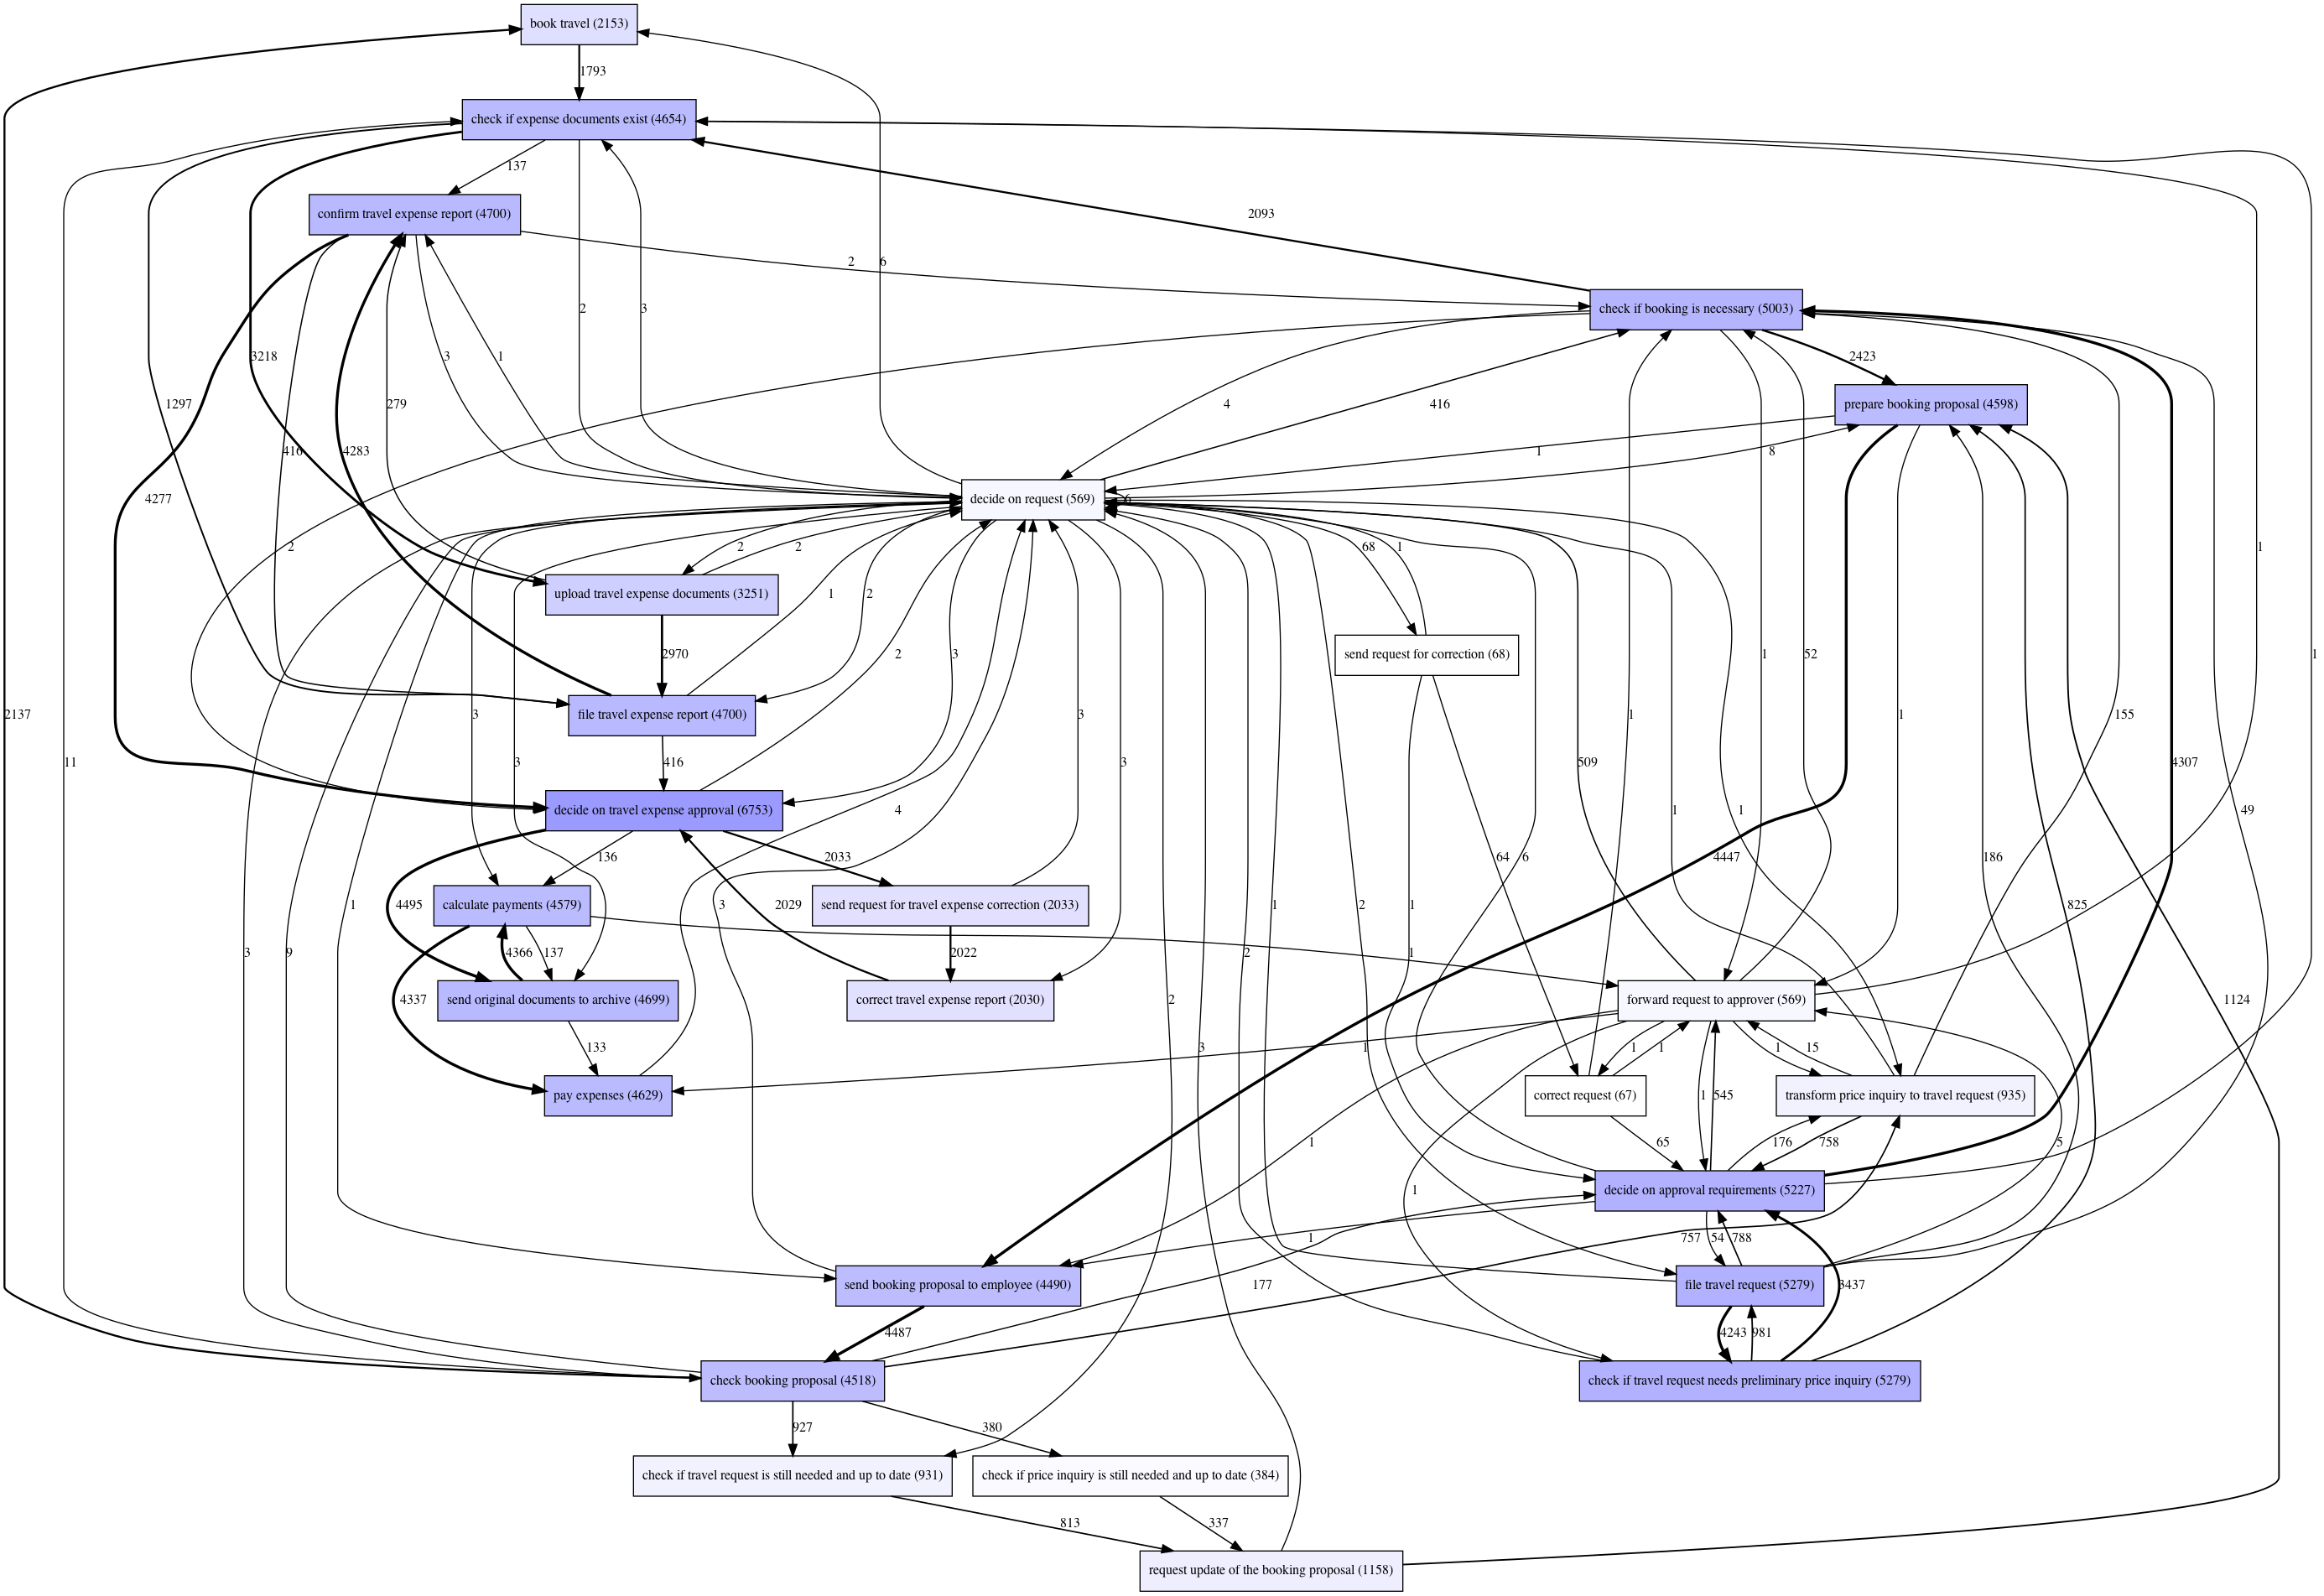

In [39]:
# DFG Discovery
import os
from pm4py.objects.log.importer.xes import importer as xes_importer
log = xes_importer.apply("logs.xes")

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(log)

from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

In [40]:
#Export Dfg
print(dfg)

Counter({('decide on travel expense approval', 'send original documents to archive'): 4495, ('send booking proposal to employee', 'check booking proposal'): 4487, ('prepare booking proposal', 'send booking proposal to employee'): 4447, ('send original documents to archive', 'calculate payments'): 4366, ('calculate payments', 'pay expenses'): 4337, ('decide on approval requirements', 'check if booking is necessary'): 4307, ('file travel expense report', 'confirm travel expense report'): 4283, ('confirm travel expense report', 'decide on travel expense approval'): 4277, ('file travel request', 'check if travel request needs preliminary price inquiry'): 4243, ('check if travel request needs preliminary price inquiry', 'decide on approval requirements'): 3437, ('check if expense documents exist', 'upload travel expense documents'): 3218, ('upload travel expense documents', 'file travel expense report'): 2970, ('check if booking is necessary', 'prepare booking proposal'): 2423, ('check book